## Import du dataset et division en données normales / anormales 

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
import pandas as pd
import glob
import os

# Chemin vers le dossier contenant les fichiers .h5
dataset_path = "./Dataset"

# Liste de tous les fichiers .h5 dans le dossier
h5_files = glob.glob(os.path.join(dataset_path, "*.h5"))

# Listes pour stocker les DataFrames normaux et anormaux
normal_data_frames = []
anomaly_data_frames = []

# Charger chaque fichier .h5 dans un DataFrame et le classer
for file in h5_files:
    try:
        df = pd.read_hdf(file)
        
        # Identifier les fichiers anormaux par la présence de mots-clés dans le nom du fichier
        if "shift_on" in file:
            anomaly_data_frames.append(df)
            print(f"{file} classé comme anomalie.")
        else:
            normal_data_frames.append(df)
            print(f"{file} classé comme normal.")
            
    except Exception as e:
        print(f"Erreur lors du chargement de {file}: {e}")


./Dataset/TimeSeries_Scenario_00001_ScenarioInstanceRandint_id_0001.h5 classé comme normal.
./Dataset/TimeSeries_Scenario_00001_ScenarioInstanceRandint_id_0001_shift_on___flight_director_pitch__flight_director_roll.h5 classé comme anomalie.
./Dataset/TimeSeries_Scenario_00002_ScenarioInstanceRandint_id_0002.h5 classé comme normal.
./Dataset/TimeSeries_Scenario_00003_ScenarioInstanceRandint_id_0003.h5 classé comme normal.
./Dataset/TimeSeries_Scenario_00004_ScenarioInstanceRandint_id_0004.h5 classé comme normal.
./Dataset/TimeSeries_Scenario_00005_ScenarioInstanceRandint_id_0005.h5 classé comme normal.
./Dataset/TimeSeries_Scenario_00006_ScenarioInstanceRandint_id_0006.h5 classé comme normal.
./Dataset/TimeSeries_Scenario_00006_ScenarioInstanceRandint_id_0006_shift_on___flight_director_pitch__flight_director_roll.h5 classé comme anomalie.
./Dataset/TimeSeries_Scenario_00007_ScenarioInstanceRandint_id_0007.h5 classé comme normal.
./Dataset/TimeSeries_Scenario_00008_ScenarioInstanceRandin

In [3]:
# Calcul du pourcentage de données normales et anormales
total_files = len(h5_files)
normal_percentage = (len(normal_data_frames) / total_files) * 100 if total_files > 0 else 0
anomaly_percentage = (len(anomaly_data_frames) / total_files) * 100 if total_files > 0 else 0

# Afficher les pourcentages
print(f"Pourcentage de données normales : {normal_percentage:.2f}%")
print(f"Pourcentage de données anormales : {anomaly_percentage:.2f}%")

#nbr de séries temporelles normales 
print(len(normal_data_frames))

Pourcentage de données normales : 96.35%
Pourcentage de données anormales : 3.65%
949


In [4]:
# vérifier que l'on ait bien des anomalies dans la liste anomaly_data_frames 

### 1. Prise en main des données et préparation à l'entrainement. 

In [5]:
# visualisation (pour l'idéeà)
print(normal_data_frames[0])

      sim/cockpit/autopilot/flight_director_pitch  \
0                                        0.017744   
1                                       -0.070592   
2                                       -0.179166   
3                                       -0.284005   
4                                       -0.365164   
...                                           ...   
3577                                     5.067928   
3578                                     5.068606   
3579                                     5.069308   
3580                                     5.069987   
3581                                     5.070647   

      sim/cockpit/autopilot/flight_director_roll  \
0                                      -0.224200   
1                                      -0.124244   
2                                      -0.124244   
3                                      -0.124244   
4                                      -0.124244   
...                                          ...   

### Concaténation en 2 dataframes principales pour la suite 

In [4]:
# Concaténer une liste de dataframes en une seule dataframe NORMAL
normal_data = pd.concat(normal_data_frames, ignore_index=True)
print(normal_data.shape)
# Extraire les valeurs
X = normal_data.values
print(normal_data)

(3399719, 135)
         sim/cockpit/autopilot/flight_director_pitch  \
0                                           0.017744   
1                                          -0.070592   
2                                          -0.179166   
3                                          -0.284005   
4                                          -0.365164   
...                                              ...   
3399714                                     5.082560   
3399715                                     5.082533   
3399716                                     5.082512   
3399717                                     5.082489   
3399718                                     5.082465   

         sim/cockpit/autopilot/flight_director_roll  \
0                                         -0.224200   
1                                         -0.124244   
2                                         -0.124244   
3                                         -0.124244   
4                                    

In [5]:
# Concaténer une liste de dataframes en une seule dataframe ANORMAL
anormal_data = pd.concat(anomaly_data_frames, ignore_index=True)
print(anormal_data.shape)
# Extraire les valeurs
Xx= anormal_data.values
print(anormal_data)

(128967, 137)
        sim/cockpit/autopilot/flight_director_pitch  \
0                                          0.017744   
1                                         -0.070592   
2                                         -0.179166   
3                                         -0.284005   
4                                         -0.365164   
...                                             ...   
128962                                     3.303244   
128963                                     3.303242   
128964                                     3.303244   
128965                                     3.303256   
128966                                     3.303262   

        sim/cockpit/autopilot/flight_director_roll  \
0                                        -0.224200   
1                                        -0.124244   
2                                        -0.124244   
3                                        -0.124244   
4                                        -0.124244   
.

### Identifier les colonnes anomalies 

In [9]:
# Comparer les colonnes des DataFrames
def identifier_nouvelles_colonnes(normal_data, anormal_data):
    # Identifier les colonnes qui sont dans anormal_data mais pas dans normal_data
    normal_columns = set(normal_data.columns)
    anormal_columns = set(anormal_data.columns)
    
    nouvelles_colonnes = anormal_columns - normal_columns  # Colonnes présentes dans anormal_data mais pas dans normal_data
    colonnes_manquantes = normal_columns - anormal_columns  # Colonnes présentes dans normal_data mais pas dans anormal_data
    
    print(f"Nombre de nouvelles colonnes dans 'anormal_data' : {len(nouvelles_colonnes)}")
    print(f"Colonnes nouvelles dans 'anormal_data' : {nouvelles_colonnes}")
    print(f"Colonnes manquantes dans 'anormal_data' par rapport à 'normal_data' : {colonnes_manquantes}")
    
    return nouvelles_colonnes

# Exemple d'appel
nouvelles_colonnes = identifier_nouvelles_colonnes(normal_data, anormal_data)

Nombre de nouvelles colonnes dans 'anormal_data' : 2
Colonnes nouvelles dans 'anormal_data' : {'sim/cockpit/autopilot/flight_director_pitch_ground_truth', 'sim/cockpit/autopilot/flight_director_roll_ground_truth'}
Colonnes manquantes dans 'anormal_data' par rapport à 'normal_data' : set()


### Affichage du paramètre présentant l'anomalie vs le normal + Calcul de sa MSE 

MSE pour sim/cockpit/autopilot/flight_director_roll_ground_truth vs sim/cockpit/autopilot/flight_director_roll: 0.4637
MSE pour sim/cockpit/autopilot/flight_director_pitch_ground_truth vs sim/cockpit/autopilot/flight_director_pitch: 11.5917


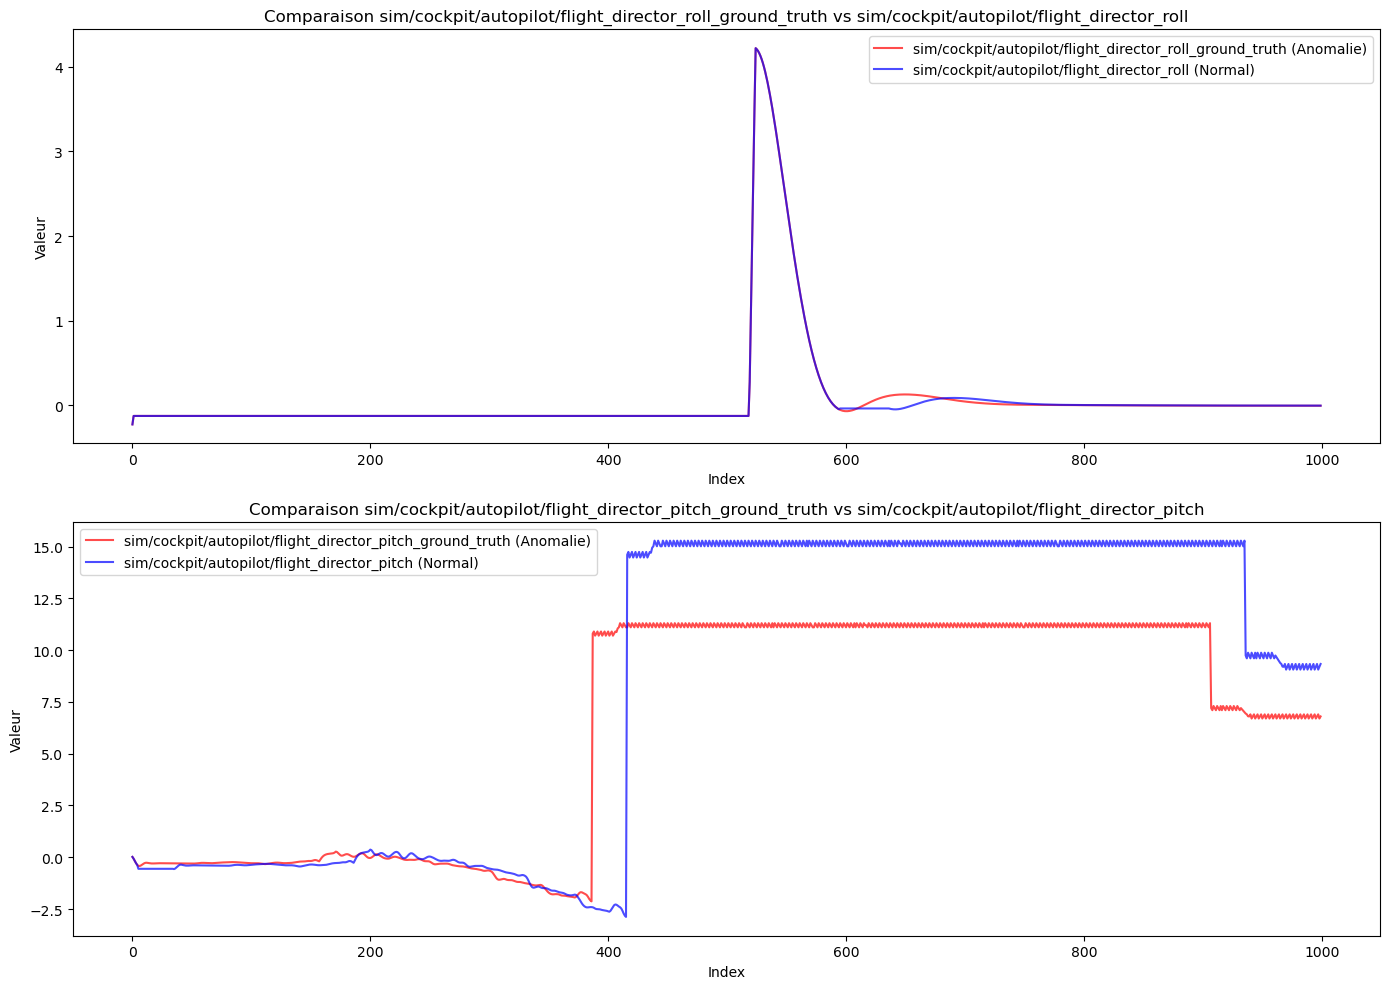

In [10]:
from sklearn.metrics import mean_squared_error

def afficher_comparaison_mse_anomalies_et_normaux(anomalie_param1, anomalie_param2, normal_param1, normal_param2, anormal_data):
    # Extraire les colonnes des données anormales et normales
    anormal_1 = anormal_data[anomalie_param1]
    anormal_2 = anormal_data[anomalie_param2]
    normal_1 = anormal_data[normal_param1]
    normal_2 = anormal_data[normal_param2]
    
    
    # Calcul de la MSE entre les paramètres anormaux et normaux 
    mse_1 = mean_squared_error(anormal_1, normal_1)  
    mse_2 = mean_squared_error(anormal_2, normal_2)  
    
    # Affichage des MSE
    print(f"MSE pour {anomalie_param1} vs {normal_param1}: {mse_1:.4f}")
    print(f"MSE pour {anomalie_param2} vs {normal_param2}: {mse_2:.4f}")
    
    # Affichage des courbes
    plt.figure(figsize=(14, 10))
    
    # Comparaison des paramètres anormaux vs normaux
    plt.subplot(2, 1, 1)
    plt.plot(anormal_1[:1000], label=f'{anomalie_param1} (Anomalie)', color='red', alpha=0.7)
    plt.plot(normal_1[:1000], label=f'{normal_param1} (Normal)', color='blue', alpha=0.7)
    plt.title(f"Comparaison {anomalie_param1} vs {normal_param1}")
    plt.legend()
    plt.xlabel("Index")
    plt.ylabel("Valeur")
    
    plt.subplot(2, 1, 2)
    plt.plot(anormal_2[:1000], label=f'{anomalie_param2} (Anomalie)', color='red', alpha=0.7)
    plt.plot(normal_2[:1000], label=f'{normal_param2} (Normal)', color='blue', alpha=0.7)
    plt.title(f"Comparaison {anomalie_param2} vs {normal_param2}")
    plt.legend()
    plt.xlabel("Index")
    plt.ylabel("Valeur")
    
    # Affichage global
    plt.tight_layout()
    plt.show()

# Exemple d'appel de la fonction
afficher_comparaison_mse_anomalies_et_normaux(
    'sim/cockpit/autopilot/flight_director_roll_ground_truth', 
    'sim/cockpit/autopilot/flight_director_pitch_ground_truth',
    'sim/cockpit/autopilot/flight_director_roll',
    'sim/cockpit/autopilot/flight_director_pitch',
    anormal_data
)




### Données pour l'entrainement - dataframe normal_data

In [18]:
param_anormaux = ['sim/cockpit/autopilot/flight_director_roll_ground_truth' , 'sim/cockpit/autopilot/flight_director_pitch_ground_truth']
param_normaux = ['sim/cockpit/autopilot/flight_director_roll' , 'sim/cockpit/autopilot/flight_director_pitch']

In [19]:
train_set = normal_data[param_normaux]
print('Training shape :', train_set.shape)

Training shape : (3399719, 2)


In [20]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

preprocess = True

if preprocess:
    # # create directory (if doesnt exist)
    # directory_path = './scaler/'
    # if not os.path.exists(directory_path):
    #     os.makedirs(directory_path)
    #     print('Created Directory')
    # else:
    #     print('Directory already exists!')
    
    window = 40
    train_set = train_set.rolling(window).mean()
    # due to the moving average we the first (window-1) rows become NaN so we remove them
    train_set = train_set.loc[window-1:]
    print('Before Normalizing')
    display(train_set.describe())
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler = scaler.fit(train_set)
    names = train_set.columns
    train_set[names] = scaler.transform(train_set[names])
    print('After Normalizing')
    display(train_set.describe())
    # save_path = os.path.join(directory_path,'Normalizing_window30.pkl')

    # print out the shape
    print(train_set.shape)

Before Normalizing


,sim/cockpit/autopilot/flight_director_roll,sim/cockpit/autopilot/flight_director_pitch
count,3.399680e+06,3.399680e+06
mean,-2.129798e-02,6.876668e+00
std,7.600776e-01,3.250063e+00
min,-2.000000e+01,-1.846477e+00
25%,-1.026736e-02,5.091604e+00
50%,-7.602766e-03,7.081802e+00
75%,-5.783012e-03,9.117484e+00
max,1.016173e+01,1.665389e+01


After Normalizing


,sim/cockpit/autopilot/flight_director_roll,sim/cockpit/autopilot/flight_director_pitch
count,3.399680e+06,3.399680e+06
mean,3.247717e-01,-5.697585e-02
std,5.040014e-02,3.513513e-01
min,-1.000000e+00,-1.000000e+00
25%,3.255031e-01,-2.499520e-01
50%,3.256798e-01,-3.479964e-02
75%,3.258004e-01,1.852698e-01
max,1.000000e+00,1.000000e+00


(3399680, 2)


In [21]:
# we set the data in a window form, in case of timestep = 5
# i=0: X_0=[x(0)..x(5)], y=x(6)
def to_sequence(data, timesteps=1):
    n_features=data.shape[2]
    seq = []
    for i in range(len(data)-timesteps):
        # takes a window of data of specified timesteps
        temp = data[i:(i+timesteps)]
        temp = temp.reshape(timesteps, n_features)
        seq.append(temp)
        
    return np.array(seq)

def to_nooverlap_sequence(data, timesteps=1):
    x = []
    for i in np.arange(0,len(data)-1,timesteps):
        _x = data[i:i+timesteps]
#         print(_x)
        x.append(_x)
        
    return np.array(x)



In [22]:
# 70% is training data
train_size = int(len(train_set)*0.7)
test = len(train_set) - train_size

train, test = train_set.iloc[:train_size], train_set.iloc[train_size:]


In [23]:
print(train.shape)
print(test.shape)

(2379776, 2)
(1019904, 2)


In [24]:
TIMESTEP = 50

# train
train = np.expand_dims(train, axis=1)
x_train = to_sequence(train, timesteps=TIMESTEP)
# test
test = np.expand_dims(test, axis=1)
x_test = to_sequence(test, timesteps=TIMESTEP)

In [25]:
def repeat(x_inp):
    x, inp = x_inp
    x = tf.expand_dims(x,1)
    x = tf.repeat(x, [tf.shape(inp)[1]],axis=1)
    return x

n_features = x_train.shape[2]

input_layer = keras.layers.Input(shape=(None, n_features))
lstm1 = keras.layers.LSTM(units=64, activation='tanh', name='LSTM_1', return_sequences=False)(input_layer)
dropout1 = keras.layers.Dropout(0.1)(lstm1)

code = keras.layers.Lambda(repeat)([dropout1, input_layer])

lstm3 = keras.layers.LSTM(units=64, activation='tanh', name='LSTM_2', return_sequences=True)(code)
out = keras.layers.TimeDistributed(keras.layers.Dense(units=n_features))(lstm3)


model = keras.Model(input_layer, outputs=out)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")

In [26]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_1 (LSTM)       │ (None, 64)        │     17,152 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ LSTM_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, None, 64)  │          0 │ dropout[0][0],    │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM_2 (LSTM)       │ (None, None, 64)  │     33,024 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, None, 2)   │        130 │ LSTM_2[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 50,306 (196.51 KB)

 Trainable params: 50,306 (196.51 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# define early stopping to prevent overfit
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", 
                                               patience=10, 
                                               mode="min", 
                                               verbose=1,
                                               restore_best_weights=True)

In [ ]:
# we train autoencoder, so both train data and labels are equal to x_train
history = model.fit(x_train, x_train,
            epochs=5,
            batch_size=512,
            validation_data=(x_test, x_test),
            callbacks=[early_stopping],
            verbose=True)

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.grid()
plt.legend()
plt.show()

In [12]:
import numpy as np

# 1. Extraction du paramètre d'intérêt
param_normal = "sim/cockpit/autopilot/flight_director_roll"
param_anomalous = "sim/cockpit/autopilot/flight_director_roll_ground_truth"

# Fonction pour tronquer les séries et extraire le paramètre spécifié
def preprocess_data(data_frames, param_name):
    """Tronquer les séries et extraire le paramètre spécifié, tout en gérant les erreurs."""
    processed_data = []
    for df in data_frames:
        if param_name not in df.columns:
            print(f"Paramètre {param_name} manquant dans l'un des DataFrames, ignoré.")
            continue  # Ignorer les DataFrames sans le paramètre
        if df.shape[0] > 3582:
            df = df.iloc[:3582]  # Tronquer à 3582
        processed_data.append(df[param_name].values)
    return np.array([x for x in processed_data if len(x) == 3582])  # S'assurer d'une longueur homogène

# Normal data
normal_processed = preprocess_data(normal_data_frames, param_normal)

# Anomalous data
anomalous_processed = preprocess_data(anomaly_data_frames, param_anomalous)

# 2. Création des ensembles d'entraînement et de test
from sklearn.model_selection import train_test_split

# Diviser les données normales
normal_train, normal_test = train_test_split(normal_processed, test_size=0.3, random_state=42)

# Concaténer pour le test final (30% normal + anormal)
X_train = normal_train  # Entraînement uniquement normal
X_test = np.concatenate((normal_test, anomalous_processed), axis=0)  # Test mixte

# Labels pour l'ensemble de test
y_test = np.array([0] * len(normal_test) + [1] * len(anomalous_processed))  # 0 = normal, 1 = anormal

# Transposition des dimensions
X_train = X_train.T  # Shape: (3582, n_samples_train)
X_test = X_test.T    # Shape: (3582, n_samples_test)
y_test = y_test      # Labels restent inchangés

# Vérification des nouvelles dimensions
print(f"X_train shape (transposed): {X_train.shape}")
print(f"X_test shape (transposed): {X_test.shape}")
print(f"y_test shape: {y_test.shape}")




X_train shape (transposed): (3582, 655)
X_test shape (transposed): (3582, 317)
y_test shape: (317,)


In [14]:
# LSTM

from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed

# Dimensions des données
time_steps = X_train_expanded.shape[1]  # 3582
features = X_train_expanded.shape[2]  # 1

# Construction de l'autoencodeur LSTM
autoencoder = Sequential([
    # Encoder
    LSTM(128, activation='relu', input_shape=(time_steps, features), return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    
    # Bottleneck
    RepeatVector(time_steps),  # Reproduit la dimension temporelle
    
    # Decoder
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(128, activation='relu', return_sequences=True),
    TimeDistributed(Dense(features))  # Sortie au même format que l'entrée
])

# Compilation
autoencoder.compile(optimizer='adam', loss='mse')feature_list = ['Fx','Fy','Fz','Mx','My']
TIMESTEP = 50

# Résumé du modèle
autoencoder.summary()


# Dimensions correctes pour les LSTM
time_steps = X_train.shape[1]  # 3582 (longueur temporelle)
n_features_train = X_train.shape[0]  # 655 (nombre d'échantillons)

n_features_test = X_test.shape[0]  # 317 (nombre d'échantillons pour test)

# 4. Préparation des données
X_train_expanded = X_train.T.reshape((n_features_train, time_steps, 1))  # (samples, time_steps, features)
X_test_expanded = X_test.T.reshape((n_features_test, time_steps, 1))  # (samples, time_steps, features)

print("X_train_expanded shape:", X_train_expanded.shape)
print("X_test_expanded shape:", X_test_expanded.shape)


NameError: name 'X_train_expanded' is not defined

In [ ]:
# ENTRAINEMENT 
import time

# Entraînement avec suivi de la perte et du temps
epochs = 5
batch_size = 32

for epoch in range(1, epochs + 1):
    start_time = time.time()
    
    # Entraînement pour une epoch
    history = autoencoder.fit(
        X_train_expanded,
        X_train_expanded,  # Sortie identique à l'entrée
        epochs=1,  # Entraînement pour une seule époque
        batch_size=batch_size,
        validation_split=0.2,
        verbose=0  # Désactiver la sortie verbose de fit()
    )
    
    # Calcul du temps écoulé
    elapsed_time = time.time() - start_time
    
    # Affichage des informations
    train_loss = history.history['loss'][0]
    val_loss = history.history['val_loss'][0]
    print(f"Epoch {epoch}/{epochs} - Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Time: {elapsed_time:.2f}s")



Epoch 1/5


In [ ]:
# 3. Traitement des données normales

# 3.1 Gestion des valeurs manquantes
X = np.nan_to_num(X)

# 3.2 Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3.3 Analyse statistique descriptive
# Statistiques de base
data_descriptive_stats = pd.DataFrame(X_scaled).describe()
print("Statistiques descriptives des données normalisées :\n", data_descriptive_stats)

In [ ]:
# 2. Division des données en train (70%) et test (30%)
X_train, X_test = train_test_split(X_scaled, test_size=0.3, random_state=42)

timesteps = 10  
n_features = X_train.shape[1]

# Reshape des données à revoir ....
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], timesteps, n_features // timesteps))
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], timesteps, n_features // timesteps))

In [ ]:
# 5. Création du modèle LSTM Auto-Encodeur
# Définition de l'architecture LSTM Auto-Encodeur

#Modèle trouvé en OPEN SOURCE mais à adapter bien sur...

input_dim = X_train_reshaped.shape[2]

input_layer = Input(shape=(timesteps, input_dim))
encoder = LSTM(64, activation="relu", return_sequences=True)(input_layer)
encoder = LSTM(32, activation="relu", return_sequences=False)(encoder)
decoder = RepeatVector(timesteps)(encoder)
decoder = LSTM(32, activation="relu", return_sequences=True)(decoder)
decoder = LSTM(64, activation="relu", return_sequences=True)(decoder)
output_layer = TimeDistributed(Dense(input_dim))(decoder)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()


